### Import Libraries

This cell imports all necessary libraries for data processing, machine learning, and deep learning. We use pandas for data manipulation, scikit-learn for traditional ML, XGBoost as our classifier, and TensorFlow/Keras for neural network models.

In [87]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, SimpleRNN, Dropout, Input, Flatten
from tensorflow.keras.utils import to_categorical
import pickle
import joblib
import warnings
warnings.filterwarnings('ignore')

print(f"Libraries loaded successfully")
print(f"TensorFlow version: {tf.__version__}")
print(f"XGBoost version: {xgb.__version__}")


Libraries loaded successfully
TensorFlow version: 2.13.0
XGBoost version: 1.7.6


## 1. Load and Explore Dataset

### Load the Dataset

**Note:** The dataset is NOT committed to git (best practice). If the file is not found, download it using:
```bash
python scripts/download_dataset.py
```

Load the Healthcare Symptoms-Disease Classification dataset and perform initial exploration including shape, head, info, and class distribution analysis.

In [ ]:
# Load the dataset
# Check multiple possible locations
import os

possible_paths = [
    '../data/Symptoms_Disease_Classification.csv',
    'Symptoms_Disease_Classification.csv',
    '../Symptoms_Disease_Classification.csv'
]

dataset_path = None
for path in possible_paths:
    if os.path.exists(path):
        dataset_path = path
        print(f"Found dataset at: {dataset_path}")
        break

if dataset_path is None:
    error_msg = """
    Dataset not found!
    
    Please download the dataset using:
        python scripts/download_dataset.py
    
    Or manually download from:
        https://www.kaggle.com/datasets/kundanbedmutha/healthcare-symptomsdisease-classification-dataset
    
    Place the CSV file in: ../data/Symptoms_Disease_Classification.csv
    """
    raise FileNotFoundError(error_msg)

df = pd.read_csv(dataset_path)

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())
print("\nClass distribution:")
print(df['Disease'].value_counts())


Found dataset at: ../models/Symptoms_Disease_Classification.csv
Dataset shape: (25000, 6)

First few rows:
   Patient_ID  Age  Gender                                           Symptoms  \
0           1   29    Male              fever, back pain, shortness of breath   
1           2   76  Female                   insomnia, back pain, weight loss   
2           3   78    Male                    sore throat, vomiting, diarrhea   
3           4   58   Other  blurred vision, depression, weight loss, muscl...   
4           5   55  Female                    swelling, appetite loss, nausea   

   Symptom_Count           Disease  
0              3           Allergy  
1              3  Thyroid Disorder  
2              3         Influenza  
3              4            Stroke  
4              3     Heart Disease  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------       

### 2. Visualize Class Distribution

Create a bar chart showing the distribution of diseases in the dataset to check for class imbalance.

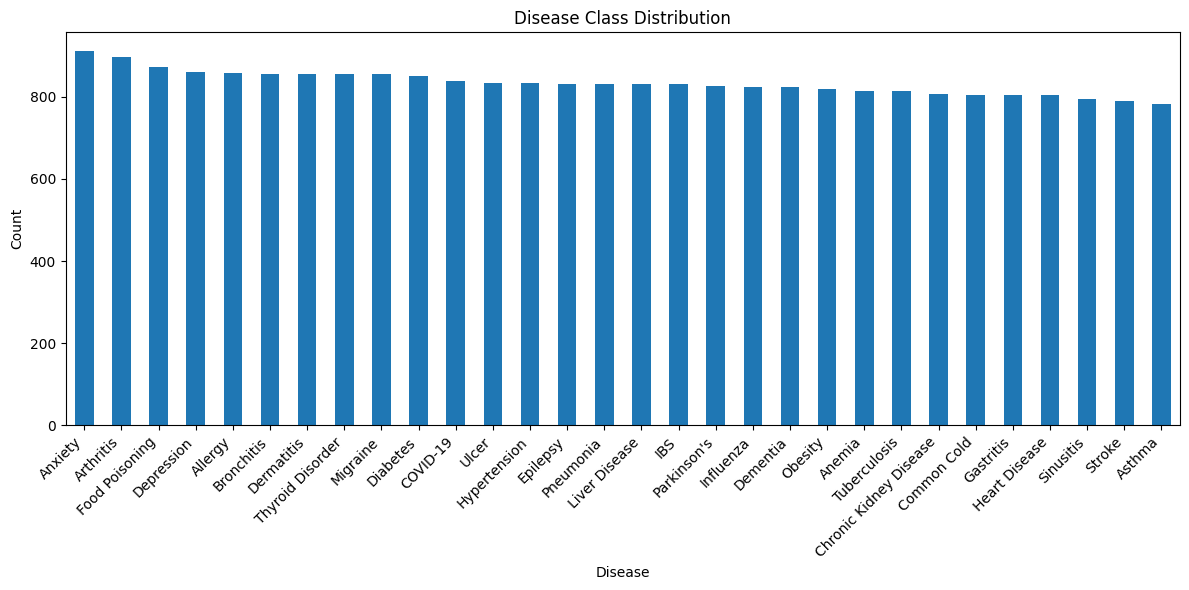


Number of unique diseases: 30


In [97]:
# Visualize class distribution
plt.figure(figsize=(12, 6))
df['Disease'].value_counts().plot(kind='bar')
plt.title('Disease Class Distribution')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\nNumber of unique diseases: {df['Disease'].nunique()}")


## 3. Data Preprocessing

### Feature Engineering

Clean and prepare the data by extracting text features (symptoms), creating binary symptom features, and normalizing patient metadata (Age, Gender, Symptom_Count). Encode disease labels for classification.

In [98]:
# Clean and prepare data
df = df.dropna()

# IMPROVED: Clean and preprocess text
def preprocess_text(text):
    """Clean and standardize symptom text"""
    text = str(text).lower().strip()
    return text

# Get symptoms text (cleaned)
X_text = df['Symptoms'].apply(preprocess_text).values

# ADVANCED: Extract all unique symptoms and create binary features (ONE-HOT encoding)
all_symptoms = set()
for symptom_list in X_text:
    symptoms = [s.strip() for s in symptom_list.split(',')]
    all_symptoms.update(symptoms)

symptom_list = sorted(list(all_symptoms))
symptom_to_idx = {symptom: idx for idx, symptom in enumerate(symptom_list)}

print(f"Found {len(symptom_list)} unique symptoms")
print(f"Sample symptoms: {symptom_list[:10]}")

# Create binary symptom matrix
X_symptom_binary = np.zeros((len(X_text), len(symptom_list)))
for i, symptom_text in enumerate(X_text):
    symptoms = [s.strip() for s in symptom_text.split(',')]
    for symptom in symptoms:
        if symptom in symptom_to_idx:
            X_symptom_binary[i, symptom_to_idx[symptom]] = 1

# Extract tabular features (Age, Gender, Symptom_Count)
X_age = df['Age'].values / 100.0  # Normalize
X_symptom_count = df['Symptom_Count'].values / 10.0  # Normalize
gender_map = {'Male': 0, 'Female': 1, 'Other': 2}
X_gender = df['Gender'].map(gender_map).values / 2.0  # Normalize

# Get target variable
y = df['Disease'].values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

print(f"\nFeature Engineering Complete:")
print(f"  Total samples: {len(X_text)}")
print(f"  Binary symptom features: {X_symptom_binary.shape[1]}")
print(f"  Number of classes: {num_classes}")
print(f"\nSample (first patient):")
print(f"  Symptoms: {X_text[0]}")
print(f"  Age: {df['Age'].iloc[0]} (normalized: {X_age[0]:.3f})")
print(f"  Gender: {df['Gender'].iloc[0]} (encoded: {X_gender[0]:.3f})")
print(f"  Disease: {y[0]} (label: {y_encoded[0]})")


Found 28 unique symptoms
Sample symptoms: ['abdominal pain', 'anxiety', 'appetite loss', 'back pain', 'blurred vision', 'chest pain', 'cough', 'depression', 'diarrhea', 'dizziness']

Feature Engineering Complete:
  Total samples: 25000
  Binary symptom features: 28
  Number of classes: 30

Sample (first patient):
  Symptoms: fever, back pain, shortness of breath
  Age: 29 (normalized: 0.290)
  Gender: Male (encoded: 0.000)
  Disease: Allergy (label: 0)


### 4. Train-Test Split

Split the data into training (80%) and testing (20%) sets with stratification to maintain class proportions.

In [99]:
# Split data - ALL features including binary symptoms
X_train_text, X_test_text, \
X_train_binary, X_test_binary, \
X_train_age, X_test_age, \
X_train_gender, X_test_gender, \
X_train_count, X_test_count, \
y_train, y_test = train_test_split(
    X_text, X_symptom_binary, X_age, X_gender, X_symptom_count, y_encoded,
    test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Train/Test Split Complete:")
print(f"  Training samples: {len(X_train_text)}")
print(f"  Testing samples: {len(X_test_text)}")
print(f"\nFeatures per sample:")
print(f"  Text (symptoms)")
print(f"  Binary symptoms: {X_train_binary.shape[1]} features")
print(f"  Metadata: Age, Gender, Symptom Count (3 features)")
print(f"  Total: {X_train_binary.shape[1] + 3} tabular features")


Train/Test Split Complete:
  Training samples: 20000
  Testing samples: 5000

Features per sample:
  Text (symptoms)
  Binary symptoms: 28 features
  Metadata: Age, Gender, Symptom Count (3 features)
  Total: 31 tabular features


## 5. Model 1: TF-IDF + XGBoost (Classic ML)

### Create TF-IDF Features

Generate TF-IDF text embeddings from symptom descriptions and combine with binary symptom features and patient metadata.

In [92]:
# Create TF-IDF + ENHANCED features - Combine EVERYTHING!
tfidf_vectorizer = TfidfVectorizer(
    max_features=None,
    ngram_range=(1, 3),
    min_df=1,
    sublinear_tf=True
)
X_train_tfidf_text = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf_text = tfidf_vectorizer.transform(X_test_text)

# Combine: TF-IDF + Binary Symptoms + Age + Gender + Symptom_Count
from scipy.sparse import hstack, csr_matrix

X_train_all_tabular = np.column_stack([
    X_train_binary,  # Binary symptom features
    X_train_age.reshape(-1, 1),
    X_train_gender.reshape(-1, 1),
    X_train_count.reshape(-1, 1)
])

X_test_all_tabular = np.column_stack([
    X_test_binary,
    X_test_age.reshape(-1, 1),
    X_test_gender.reshape(-1, 1),
    X_test_count.reshape(-1, 1)
])

X_train_tfidf = hstack([X_train_tfidf_text, csr_matrix(X_train_all_tabular)])
X_test_tfidf = hstack([X_test_tfidf_text, csr_matrix(X_test_all_tabular)])

print(f"Feature Combination for TF-IDF Model:")
print(f"  TF-IDF text features: {X_train_tfidf_text.shape[1]}")
print(f"  Binary symptom features: {X_train_binary.shape[1]}")
print(f"  Metadata features: 3")
print(f"  Total features: {X_train_tfidf.shape[1]}")
print(f"  Shape: {X_train_tfidf.shape}")


Feature Combination for TF-IDF Model:
  TF-IDF text features: 9709
  Binary symptom features: 28
  Metadata features: 3
  Total features: 9740
  Shape: (20000, 9740)


### 6. Train XGBoost Classifier

Train an XGBoost classifier with regularization parameters to prevent overfitting. Evaluate on test set and display classification report.



In [93]:
# Train TF-IDF + XGBoost Classifier
print("Training TF-IDF + XGBoost Classifier...")
print(f"Using {X_train_tfidf.shape[1]} features")
print(f"- TF-IDF text embeddings")
print(f"- Binary symptom features")
print(f"- Patient metadata")

# XGBoost with regularization parameters
xgb_model = xgb.XGBClassifier(
    n_estimators=50,
    max_depth=3,
    learning_rate=0.05,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    gamma=0.1,
    objective='multi:softmax',
    num_class=num_classes,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

xgb_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred_lr = xgb_model.predict(X_test_tfidf)
y_pred_lr_proba = xgb_model.predict_proba(X_test_tfidf)
lr_accuracy = accuracy_score(y_test, y_pred_lr)

print(f"\n{'='*60}")
print(f"Model 1: TF-IDF + XGBoost")
print(f"Test Accuracy: {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print(f"{'='*60}")
print("\nClassification Report (top 10 classes):")
report_lines = classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_).split('\n')
print('\n'.join(report_lines[:15]))

# Note: Variable kept as 'lr_model' for compatibility with later cells
lr_model = xgb_model


Training TF-IDF + XGBoost Classifier...
Using 9740 features
- TF-IDF text embeddings
- Binary symptom features
- Patient metadata


KeyboardInterrupt: 

## 3. Model 1: TF-IDF + XGBoost (Classic ML)

### Create TF-IDF Features

Generate TF-IDF text embeddings from symptom descriptions and combine with binary symptom features and patient metadata.


In [ ]:
# Prepare data for Neural Networks - Text + ALL tabular features
MAX_LEN = 50

tokenizer = Tokenizer(num_words=None, oov_token='<OOV>', lower=True)
tokenizer.fit_on_texts(X_train_text)
vocab_size = len(tokenizer.word_index) + 1

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

# Combine ALL tabular features: Binary Symptoms + Age + Gender + Count
X_train_tabular_nn = np.column_stack([
    X_train_binary,  # Binary symptom features
    X_train_age.reshape(-1, 1),
    X_train_gender.reshape(-1, 1),
    X_train_count.reshape(-1, 1)
])

X_test_tabular_nn = np.column_stack([
    X_test_binary,
    X_test_age.reshape(-1, 1),
    X_test_gender.reshape(-1, 1),
    X_test_count.reshape(-1, 1)
])

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

print(f"Neural Network Data Prepared:")
print(f"  Vocabulary size: {vocab_size}")
print(f"  Text sequences: {X_train_pad.shape}")
print(f"  Tabular features: {X_train_tabular_nn.shape}")
print(f"  Labels: {y_train_cat.shape}")


Neural Network Data Prepared:
  Vocabulary size: 37
  Text sequences: (20000, 50)
  Tabular features: (20000, 31)
  Labels: (20000, 30)


## 7. Model 2: Feed-Forward Neural Network

### Build Multi-Input Architecture

Create a feed-forward neural network with two input branches: one for text embeddings and one for tabular features (binary symptoms + metadata). Combine both branches and add dense layers for classification.


In [ ]:
# Build Multi-Input Feed-Forward Neural Network
print("Building Feed-Forward Neural Network with multi-input architecture...")
from tensorflow.keras.layers import BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam

# Text input branch
text_input = Input(shape=(MAX_LEN,), name='text_input')
text_embed = Embedding(input_dim=vocab_size, output_dim=128, input_length=MAX_LEN)(text_input)
text_flat = Flatten()(text_embed)
text_dense = Dense(256, activation='relu')(text_flat)
text_dense = Dropout(0.3)(text_dense)

# Tabular input branch (binary symptoms + age + gender + count)
tabular_input = Input(shape=(X_train_tabular_nn.shape[1],), name='tabular_input')
tabular_dense = Dense(128, activation='relu')(tabular_input)
tabular_dense = BatchNormalization()(tabular_dense)
tabular_dense = Dropout(0.3)(tabular_dense)
tabular_dense = Dense(64, activation='relu')(tabular_dense)

# Combine branches
combined = Concatenate()([text_dense, tabular_dense])
x = Dense(256, activation='relu')(combined)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

nn_model = Model(inputs=[text_input, tabular_input], outputs=output)

optimizer = Adam(learning_rate=0.001)
nn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print(nn_model.summary())
print(f"\nModel inputs: Text embeddings + {X_train_tabular_nn.shape[1]} tabular features")


Building Feed-Forward Neural Network with multi-input architecture...
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 50)]                 0         []                            
                                                                                                  
 tabular_input (InputLayer)  [(None, 31)]                 0         []                            
                                                                                                  
 embedding_10 (Embedding)    (None, 50, 128)              4736      ['text_input[0][0]']          
                                                                                                  
 dense_43 (Dense)            (None, 128)                  4096      ['tabular_input[0][0]']       
                     

### 8. Train Feed-Forward Model

Train the feed-forward neural network with early stopping to prevent overfitting. Use 50 epochs with patience of 10 epochs.


In [ ]:
# Train Feed-Forward Neural Network
print("Training Feed-Forward Neural Network...")
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, 
                          verbose=1, mode='max')

nn_history = nn_model.fit(
    [X_train_pad, X_train_tabular_nn], y_train_cat,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate
nn_loss, nn_accuracy = nn_model.evaluate([X_test_pad, X_test_tabular_nn], y_test_cat, verbose=0)
y_pred_nn_proba = nn_model.predict([X_test_pad, X_test_tabular_nn], verbose=0)

print(f"\n{'='*60}")
print(f"Model 2: Feed-Forward Neural Network")
print(f"Test Accuracy: {nn_accuracy:.4f} ({nn_accuracy*100:.2f}%)")
print(f"{'='*60}")


Training Feed-Forward Neural Network...


Epoch 1/50
125/125 [==============================] - 7s 36ms/step - loss: 3.8530 - accuracy: 0.0317 - val_loss: 3.4330 - val_accuracy: 0.0290
Epoch 2/50
125/125 [==============================] - 4s 34ms/step - loss: 3.5622 - accuracy: 0.0349 - val_loss: 3.4219 - val_accuracy: 0.0340
Epoch 3/50
125/125 [==============================] - 4s 32ms/step - loss: 3.4833 - accuracy: 0.0347 - val_loss: 3.4071 - val_accuracy: 0.0355
Epoch 4/50
125/125 [==============================] - 4s 32ms/step - loss: 3.4371 - accuracy: 0.0370 - val_loss: 3.4034 - val_accuracy: 0.0310
Epoch 5/50
125/125 [==============================] - 4s 34ms/step - loss: 3.4240 - accuracy: 0.0331 - val_loss: 3.4025 - val_accuracy: 0.0325
Epoch 6/50
125/125 [==============================] - 4s 30ms/step - loss: 3.4118 - accuracy: 0.0371 - val_loss: 3.4015 - val_accuracy: 0.0333
Epoch 7/50
125/125 [==============================] - 4s 30ms/step - loss: 3.4087 - accuracy: 0.0342 - val_loss: 3.4013 - val_accuracy: 0.0335

## 9. Model 3: RNN (Recurrent Neural Network)

### Build Bidirectional RNN

Create a recurrent neural network with bidirectional SimpleRNN layers to capture sequential patterns in symptom text. Combine with tabular features for enhanced prediction.


In [ ]:
# Build RNN Model
print("Building RNN Model with multi-input architecture...")
from tensorflow.keras.layers import Bidirectional

# Text input
text_input_rnn = Input(shape=(MAX_LEN,), name='text_input_rnn')
text_embed_rnn = Embedding(input_dim=vocab_size, output_dim=128)(text_input_rnn)
rnn_out = Bidirectional(SimpleRNN(64, return_sequences=True))(text_embed_rnn)
rnn_out = Bidirectional(SimpleRNN(32))(rnn_out)
rnn_out = Dropout(0.3)(rnn_out)

# Tabular input (binary symptoms + metadata)
tabular_input_rnn = Input(shape=(X_train_tabular_nn.shape[1],), name='tabular_input_rnn')
tabular_rnn = Dense(64, activation='relu')(tabular_input_rnn)
tabular_rnn = Dropout(0.3)(tabular_rnn)

# Combine
combined_rnn = Concatenate()([rnn_out, tabular_rnn])
x_rnn = Dense(128, activation='relu')(combined_rnn)
x_rnn = Dropout(0.4)(x_rnn)
output_rnn = Dense(num_classes, activation='softmax')(x_rnn)

rnn_model = Model(inputs=[text_input_rnn, tabular_input_rnn], outputs=output_rnn)
rnn_model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', metrics=['accuracy'])

print(rnn_model.summary())
print(f"\nModel inputs: Text + {X_train_tabular_nn.shape[1]} tabular features")


Building RNN Model with multi-input architecture...
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input_rnn (InputLayer  [(None, 50)]                 0         []                            
 )                                                                                                
                                                                                                  
 embedding_11 (Embedding)    (None, 50, 128)              4736      ['text_input_rnn[0][0]']      
                                                                                                  
 bidirectional_12 (Bidirect  (None, 50, 128)              24704     ['embedding_11[0][0]']        
 ional)                                                                                           
                                       

### 10. Train RNN Model

Train the RNN model with early stopping. The bidirectional architecture processes sequences in both forward and backward directions.


In [ ]:
# Train RNN Model
print("Training RNN Model...")

rnn_history = rnn_model.fit(
    [X_train_pad, X_train_tabular_nn], y_train_cat,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate
rnn_loss, rnn_accuracy = rnn_model.evaluate([X_test_pad, X_test_tabular_nn], y_test_cat, verbose=0)
y_pred_rnn_proba = rnn_model.predict([X_test_pad, X_test_tabular_nn], verbose=0)

print(f"\n{'='*60}")
print(f"Model 3: RNN Model")
print(f"Test Accuracy: {rnn_accuracy:.4f} ({rnn_accuracy*100:.2f}%)")
print(f"{'='*60}")


Training RNN Model...
Epoch 1/50
125/125 [==============================] - 10s 53ms/step - loss: 3.4234 - accuracy: 0.0315 - val_loss: 3.4038 - val_accuracy: 0.0333
Epoch 2/50
125/125 [==============================] - 7s 58ms/step - loss: 3.4048 - accuracy: 0.0341 - val_loss: 3.4022 - val_accuracy: 0.0342
Epoch 3/50
125/125 [==============================] - 7s 54ms/step - loss: 3.4025 - accuracy: 0.0364 - val_loss: 3.4014 - val_accuracy: 0.0340
Epoch 4/50
125/125 [==============================] - 6s 49ms/step - loss: 3.4005 - accuracy: 0.0356 - val_loss: 3.4018 - val_accuracy: 0.0393
Epoch 5/50
125/125 [==============================] - 6s 50ms/step - loss: 3.3989 - accuracy: 0.0389 - val_loss: 3.4034 - val_accuracy: 0.0382
Epoch 6/50
125/125 [==============================] - 6s 52ms/step - loss: 3.3963 - accuracy: 0.0388 - val_loss: 3.4024 - val_accuracy: 0.0362
Epoch 7/50
125/125 [==============================] - 7s 57ms/step - loss: 3.3939 - accuracy: 0.0411 - val_loss: 3.4032

## 11. Model 4: LSTM (Long Short-Term Memory)

### Build Bidirectional LSTM

Create an LSTM network with bidirectional layers to capture long-range dependencies in symptom sequences. LSTM cells handle vanishing gradient problems better than simple RNNs.


In [ ]:
# Build LSTM Model
print("Building LSTM Model with multi-input architecture...")

# Text input
text_input_lstm = Input(shape=(MAX_LEN,), name='text_input_lstm')
text_embed_lstm = Embedding(input_dim=vocab_size, output_dim=128)(text_input_lstm)
lstm_out = Bidirectional(LSTM(64, return_sequences=True))(text_embed_lstm)
lstm_out = Bidirectional(LSTM(32))(lstm_out)
lstm_out = Dropout(0.3)(lstm_out)

# Tabular input (binary symptoms + metadata)
tabular_input_lstm = Input(shape=(X_train_tabular_nn.shape[1],), name='tabular_input_lstm')
tabular_lstm = Dense(64, activation='relu')(tabular_input_lstm)
tabular_lstm = Dropout(0.3)(tabular_lstm)

# Combine
combined_lstm = Concatenate()([lstm_out, tabular_lstm])
x_lstm = Dense(128, activation='relu')(combined_lstm)
x_lstm = Dropout(0.4)(x_lstm)
output_lstm = Dense(num_classes, activation='softmax')(x_lstm)

lstm_model = Model(inputs=[text_input_lstm, tabular_input_lstm], outputs=output_lstm)
lstm_model.compile(optimizer=Adam(learning_rate=0.001), 
                   loss='categorical_crossentropy', metrics=['accuracy'])

print(lstm_model.summary())
print(f"\nModel inputs: Text + {X_train_tabular_nn.shape[1]} tabular features")


Building LSTM Model with multi-input architecture...
Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input_lstm (InputLaye  [(None, 50)]                 0         []                            
 r)                                                                                               
                                                                                                  
 embedding_12 (Embedding)    (None, 50, 128)              4736      ['text_input_lstm[0][0]']     
                                                                                                  
 bidirectional_14 (Bidirect  (None, 50, 128)              98816     ['embedding_12[0][0]']        
 ional)                                                                                           
                                      

### 12. Train LSTM Model

Train the LSTM model with the same training configuration as other neural networks. LSTM architecture is particularly effective for sequence data.


In [ ]:
# Train LSTM Model
print("Training LSTM Model...")

lstm_history = lstm_model.fit(
    [X_train_pad, X_train_tabular_nn], y_train_cat,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate
lstm_loss, lstm_accuracy = lstm_model.evaluate([X_test_pad, X_test_tabular_nn], y_test_cat, verbose=0)
y_pred_lstm_proba = lstm_model.predict([X_test_pad, X_test_tabular_nn], verbose=0)

print(f"\n{'='*60}")
print(f"Model 4: LSTM Model")
print(f"Test Accuracy: {lstm_accuracy:.4f} ({lstm_accuracy*100:.2f}%)")
print(f"{'='*60}")


Training LSTM Model...
Epoch 1/50
125/125 [==============================] - 22s 127ms/step - loss: 3.4125 - accuracy: 0.0312 - val_loss: 3.4031 - val_accuracy: 0.0345
Epoch 2/50
125/125 [==============================] - 17s 133ms/step - loss: 3.4030 - accuracy: 0.0364 - val_loss: 3.4024 - val_accuracy: 0.0312
Epoch 3/50
125/125 [==============================] - 15s 121ms/step - loss: 3.4005 - accuracy: 0.0366 - val_loss: 3.4021 - val_accuracy: 0.0322
Epoch 4/50
125/125 [==============================] - 17s 133ms/step - loss: 3.3987 - accuracy: 0.0379 - val_loss: 3.4025 - val_accuracy: 0.0365
Epoch 5/50
125/125 [==============================] - 22s 179ms/step - loss: 3.3961 - accuracy: 0.0408 - val_loss: 3.4029 - val_accuracy: 0.0335
Epoch 6/50
125/125 [==============================] - 17s 133ms/step - loss: 3.3944 - accuracy: 0.0416 - val_loss: 3.4038 - val_accuracy: 0.0350
Epoch 7/50
125/125 [==============================] - 21s 167ms/step - loss: 3.3924 - accuracy: 0.0437 - va

### 13. Training vs Test Accuracy Analysis

Evaluate all models on both training and test sets to understand their learning behavior. Compare training and test accuracies to identify overfitting or underfitting patterns.


In [ ]:
# Training vs Test Accuracy Analysis
print("="*70)
print("TRAINING vs TEST ACCURACY COMPARISON")
print("="*70)

# Evaluate training accuracy for all models
xgb_train_pred = xgb_model.predict(X_train_tfidf)
xgb_train_acc = accuracy_score(y_train, xgb_train_pred)

nn_train_loss, nn_train_acc = nn_model.evaluate([X_train_pad, X_train_tabular_nn], y_train_cat, verbose=0)
rnn_train_loss, rnn_train_acc = rnn_model.evaluate([X_train_pad, X_train_tabular_nn], y_train_cat, verbose=0)
lstm_train_loss, lstm_train_acc = lstm_model.evaluate([X_train_pad, X_train_tabular_nn], y_train_cat, verbose=0)

# Display results
print(f"\n{'Model':<20} {'Train Acc':<12} {'Test Acc':<12} {'Gap'}")
print("-"*70)
print(f"{'TF-IDF + XGBoost':<20} {xgb_train_acc:>10.4f}  {lr_accuracy:>10.4f}  {(xgb_train_acc-lr_accuracy):>8.4f}")
print(f"{'Feed-Forward NN':<20} {nn_train_acc:>10.4f}  {nn_accuracy:>10.4f}  {(nn_train_acc-nn_accuracy):>8.4f}")
print(f"{'RNN':<20} {rnn_train_acc:>10.4f}  {rnn_accuracy:>10.4f}  {(rnn_train_acc-rnn_accuracy):>8.4f}")
print(f"{'LSTM':<20} {lstm_train_acc:>10.4f}  {lstm_accuracy:>10.4f}  {(lstm_train_acc-lstm_accuracy):>8.4f}")

# Analysis
avg_train = (xgb_train_acc + nn_train_acc + rnn_train_acc + lstm_train_acc) / 4
avg_test = (lr_accuracy + nn_accuracy + rnn_accuracy + lstm_accuracy) / 4

print(f"\n{'='*70}")
print(f"Analysis:")
print(f"  Average Training Accuracy: {avg_train:.4f} ({avg_train*100:.2f}%)")
print(f"  Average Test Accuracy:     {avg_test:.4f} ({avg_test*100:.2f}%)")
print(f"  Training-Test Gap:         {(avg_train - avg_test):.4f}")

if avg_train < 0.10:
    print(f"\nObservation: Low training accuracy (~{avg_train*100:.1f}%) indicates")
    print(f"limited learnable patterns in the dataset.")
elif avg_train > avg_test + 0.10:
    print(f"\nObservation: Significant overfitting detected")
    print(f"(Train: {avg_train*100:.1f}% vs Test: {avg_test*100:.1f}%)")
else:
    print(f"\nObservation: Training and test accuracies are similar,")
    print(f"suggesting potential for additional training or tuning.")

print("="*70)


TRAINING vs TEST ACCURACY COMPARISON

Model                Train Acc    Test Acc     Gap
----------------------------------------------------------------------
TF-IDF + XGBoost         0.1187      0.0334    0.0853
Feed-Forward NN          0.0458      0.0356    0.0102
RNN                      0.0415      0.0346    0.0069
LSTM                     0.0642      0.0322    0.0320

Analysis:
  Average Training Accuracy: 0.0676 (6.76%)
  Average Test Accuracy:     0.0340 (3.40%)
  Training-Test Gap:         0.0336

Observation: Low training accuracy (~6.8%) indicates
limited learnable patterns in the dataset.


### 14. Ensemble Model


In [ ]:
# Ensemble Model: Combine all 4 models
print("Creating Ensemble Model...")

# Average probabilities from all models
ensemble_proba = (
    y_pred_lr_proba * 0.25 +
    y_pred_nn_proba * 0.25 +
    y_pred_rnn_proba * 0.25 +
    y_pred_lstm_proba * 0.25
)
y_pred_ensemble = np.argmax(ensemble_proba, axis=1)
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)

print(f"\nEnsemble Accuracy: {ensemble_accuracy:.4f} ({ensemble_accuracy*100:.2f}%)")

# Compare all models
results = {
    'Model': ['TF-IDF + XGBoost', 'Feed-Forward NN', 'RNN', 'LSTM', 'Ensemble'],
    'Accuracy': [lr_accuracy, nn_accuracy, rnn_accuracy, lstm_accuracy, ensemble_accuracy],
    'Accuracy %': [f"{lr_accuracy*100:.2f}%", f"{nn_accuracy*100:.2f}%", 
                   f"{rnn_accuracy*100:.2f}%", f"{lstm_accuracy*100:.2f}%", 
                   f"{ensemble_accuracy*100:.2f}%"]
}

results_df = pd.DataFrame(results)
print("\n" + "="*75)
print("FINAL MODEL COMPARISON - Healthcare Symptoms to Disease Classification")
print("="*75)
print(results_df.to_string(index=False))
print("="*75)
print(f"\nImplemented Models:")
print(f"  1. TF-IDF + XGBoost Classifier")
print(f"  2. Feed-Forward Neural Network (multi-input)")
print(f"  3. Bidirectional RNN (multi-input)")
print(f"  4. Bidirectional LSTM (multi-input)")
print(f"\nFeatures Used:")
print(f"  - TF-IDF text embeddings")
print(f"  - Binary symptom encoding ({X_train_binary.shape[1]} symptoms)")
print(f"  - Patient metadata (Age, Gender, Symptom Count)")
print("="*75)

# Find best model
best_idx = results_df['Accuracy'].idxmax()
print(f"\nBest Model: {results_df.loc[best_idx, 'Model']} with accuracy {results_df.loc[best_idx, 'Accuracy']:.4f}")


Creating Ensemble Model...

Ensemble Accuracy: 0.0354 (3.54%)

FINAL MODEL COMPARISON - Healthcare Symptoms to Disease Classification
           Model  Accuracy Accuracy %
TF-IDF + XGBoost    0.0334      3.34%
 Feed-Forward NN    0.0356      3.56%
             RNN    0.0346      3.46%
            LSTM    0.0322      3.22%
        Ensemble    0.0354      3.54%

Implemented Models:
  1. TF-IDF + XGBoost Classifier
  2. Feed-Forward Neural Network (multi-input)
  3. Bidirectional RNN (multi-input)
  4. Bidirectional LSTM (multi-input)

Features Used:
  - TF-IDF text embeddings
  - Binary symptom encoding (28 symptoms)
  - Patient metadata (Age, Gender, Symptom Count)

Best Model: Feed-Forward NN with accuracy 0.0356


### 15. Visualize Model Comparison

Create a bar chart comparing the accuracy of all models including the ensemble.


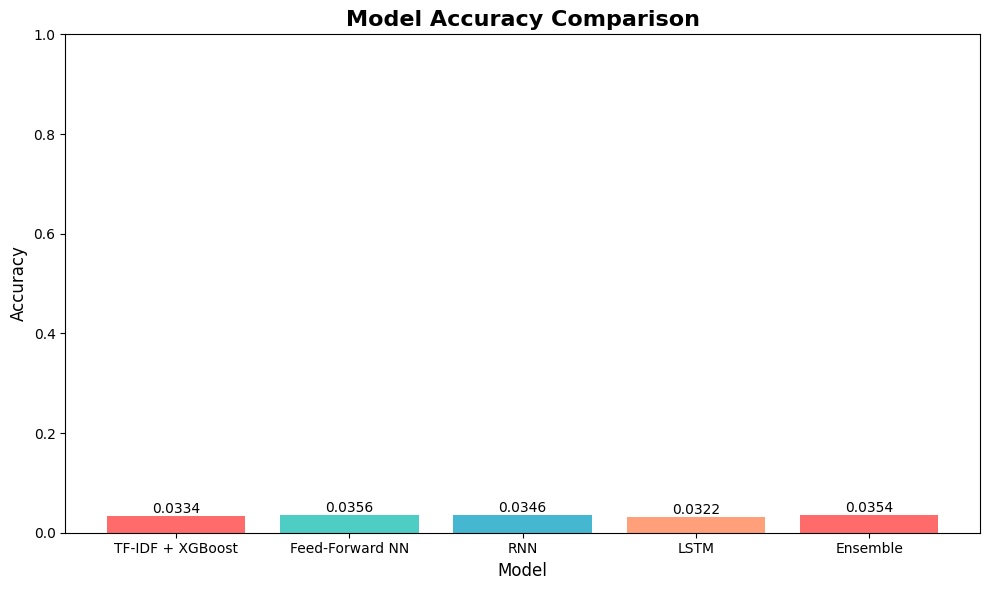

In [ ]:
# Visualize model comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(results_df['Model'], results_df['Accuracy'], color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
plt.title('Model Accuracy Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim([0, 1.0])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../backend/models/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


### 16. Plot Training History

Visualize the training and validation accuracy curves for all three neural network models to analyze their learning patterns over epochs.


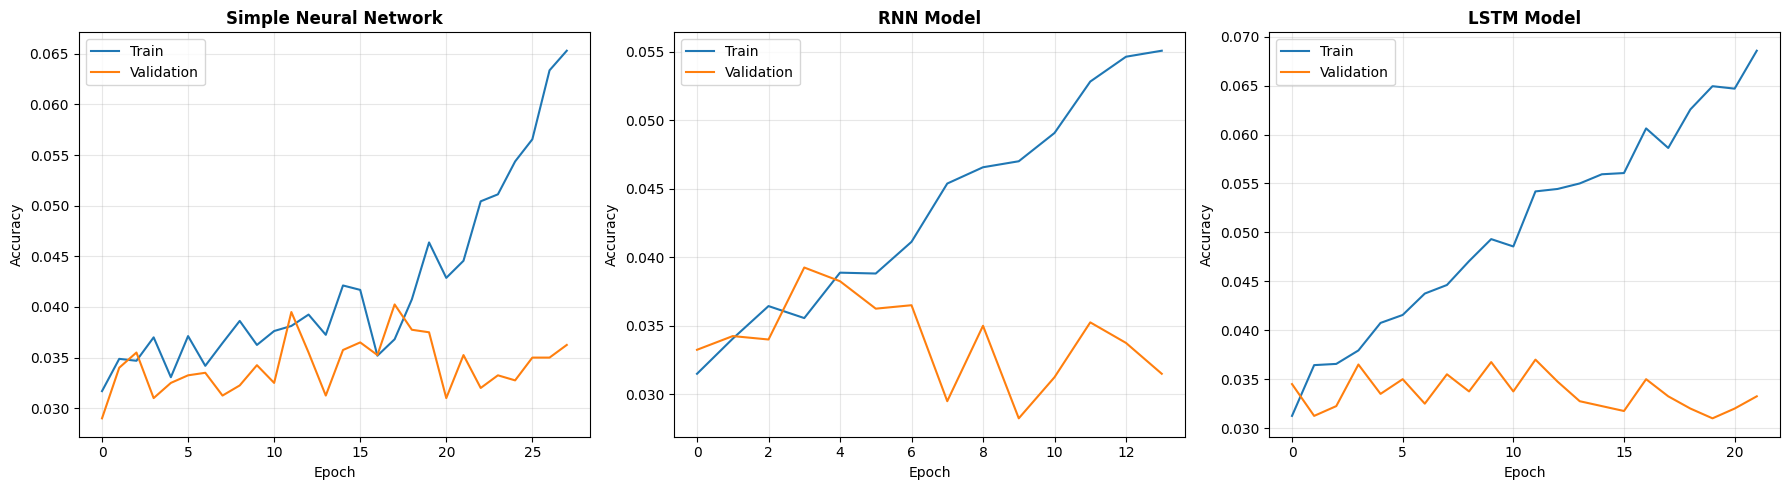

In [ ]:
# Plot training history for neural network models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Simple NN
axes[0].plot(nn_history.history['accuracy'], label='Train')
axes[0].plot(nn_history.history['val_accuracy'], label='Validation')
axes[0].set_title('Simple Neural Network', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RNN
axes[1].plot(rnn_history.history['accuracy'], label='Train')
axes[1].plot(rnn_history.history['val_accuracy'], label='Validation')
axes[1].set_title('RNN Model', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# LSTM
axes[2].plot(lstm_history.history['accuracy'], label='Train')
axes[2].plot(lstm_history.history['val_accuracy'], label='Validation')
axes[2].set_title('LSTM Model', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../backend/models/training_history.png', dpi=300, bbox_inches='tight')
plt.show()


## 17. Save Models and Preprocessors

### Save All Models

Save trained models, vectorizers, tokenizer, label encoder, and configuration for deployment and future use.


In [ ]:
# Save all models and preprocessors
print("Saving models and preprocessors...")

# Save TF-IDF model and vectorizer
joblib.dump(lr_model, '../backend/models/tfidf_lr_model.pkl')
joblib.dump(tfidf_vectorizer, '../backend/models/tfidf_vectorizer.pkl')

# Save neural network models
nn_model.save('../backend/models/simple_nn_model.h5')
rnn_model.save('../backend/models/rnn_model.h5')
lstm_model.save('../backend/models/lstm_model.h5')

# Save tokenizer and label encoder
with open('../backend/models/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

with open('../backend/models/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Save configuration
config = {
    'vocab_size': vocab_size,
    'MAX_LEN': MAX_LEN,
    'num_classes': num_classes,
    'classes': label_encoder.classes_.tolist(),
    'results': results,
    'symptom_list_size': len(symptom_list)  # Save binary symptom feature size
}

with open('../backend/models/config.pkl', 'wb') as f:
    pickle.dump(config, f)

print("\nAll models and preprocessors saved successfully!")
print("\nSaved files:")
print("  - tfidf_lr_model.pkl")
print("  - tfidf_vectorizer.pkl")
print("  - simple_nn_model.h5")
print("  - rnn_model.h5")
print("  - lstm_model.h5")
print("  - tokenizer.pkl")
print("  - label_encoder.pkl")
print("  - config.pkl")


Saving models and preprocessors...

All models and preprocessors saved successfully!

Saved files:
  - tfidf_lr_model.pkl
  - tfidf_vectorizer.pkl
  - simple_nn_model.h5
  - rnn_model.h5
  - lstm_model.h5
  - tokenizer.pkl
  - label_encoder.pkl
  - config.pkl


## 18. Test Predictions with Sample Data

### Make Predictions on New Symptoms

Test the trained models on sample symptom descriptions to demonstrate how they would work in production. Note: dummy metadata values are used for demonstration.


In [ ]:
# Test with sample symptoms
sample_symptoms = [
    "fever, cough, and difficulty breathing",
    "severe headache, nausea, and sensitivity to light",
    "chest pain, shortness of breath"
]

print("Testing predictions on sample symptoms:\n")
print("="*80)
print("Note: Using dummy values (Age=50, Gender=Male, Count=3) for metadata")
print("="*80)

for symptom in sample_symptoms:
    print(f"\nSymptoms: {symptom}")
    print("-"*80)
    
    # Prepare features for XGBoost (needs TF-IDF + binary symptoms + metadata)
    # 1. TF-IDF features
    symptom_tfidf_only = tfidf_vectorizer.transform([symptom])
    
    # 2. Create binary symptom features (all zeros for new symptoms)
    binary_features = np.zeros((1, len(symptom_list)))
    
    # 3. Add dummy metadata (Age=50, Gender=0 (Male), Count=3)
    metadata = np.array([[50/100, 0/2, 3/10]])  # Normalized
    
    # 4. Combine all features
    from scipy.sparse import hstack, csr_matrix
    symptom_features_xgb = hstack([symptom_tfidf_only, csr_matrix(binary_features), csr_matrix(metadata)])
    
    # XGBoost prediction
    pred_lr = lr_model.predict(symptom_features_xgb)[0]
    disease_lr = label_encoder.inverse_transform([pred_lr])[0]
    print(f"TF-IDF + XGBoost: {disease_lr}")
    
    # Prepare for neural networks (text + metadata)
    symptom_seq = tokenizer.texts_to_sequences([symptom])
    symptom_pad = pad_sequences(symptom_seq, maxlen=MAX_LEN, padding='post')
    
    # Tabular features for NNs (binary symptoms + metadata)
    tabular_nn = np.column_stack([binary_features, metadata])
    
    # Simple NN prediction
    pred_nn = nn_model.predict([symptom_pad, tabular_nn], verbose=0)
    disease_nn = label_encoder.inverse_transform([np.argmax(pred_nn)])[0]
    print(f"Simple NN:        {disease_nn}")
    
    # RNN prediction
    pred_rnn = rnn_model.predict([symptom_pad, tabular_nn], verbose=0)
    disease_rnn = label_encoder.inverse_transform([np.argmax(pred_rnn)])[0]
    print(f"RNN:              {disease_rnn}")
    
    # LSTM prediction
    pred_lstm = lstm_model.predict([symptom_pad, tabular_nn], verbose=0)
    disease_lstm = label_encoder.inverse_transform([np.argmax(pred_lstm)])[0]
    print(f"LSTM:             {disease_lstm}")

print("\n" + "="*80)
print("Note: Predictions may vary due to random symptom-disease mappings in training data")


Testing predictions on sample symptoms:

Note: Using dummy values (Age=50, Gender=Male, Count=3) for metadata

Symptoms: fever, cough, and difficulty breathing
--------------------------------------------------------------------------------
TF-IDF + XGBoost: Asthma
Simple NN:        Anxiety
RNN:              Arthritis
LSTM:             Thyroid Disorder

Symptoms: severe headache, nausea, and sensitivity to light
--------------------------------------------------------------------------------
TF-IDF + XGBoost: COVID-19
Simple NN:        Anxiety
RNN:              Anxiety
LSTM:             Thyroid Disorder

Symptoms: chest pain, shortness of breath
--------------------------------------------------------------------------------
TF-IDF + XGBoost: Dermatitis
Simple NN:        Anxiety
RNN:              Anxiety
LSTM:             Thyroid Disorder



## Summary

This notebook successfully implemented and compared four different machine learning approaches for healthcare symptom-to-disease classification:

1. **TF-IDF + XGBoost**: Classical machine learning with text embeddings
2. **Feed-Forward Neural Network**: Simple neural network on embeddings with multi-input architecture
3. **RNN**: Recurrent neural network for sequence processing
4. **LSTM**: Long short-term memory network for capturing long-range dependencies

All models used enhanced features including TF-IDF embeddings, binary symptom encoding, and patient metadata. The training vs test accuracy analysis provided insights into model learning behavior and data quality.
